# Atelier de Formation en Statistique Génétique et Épidémiologie Génétique STAGE-Québec
## Thème 2 - Phénotypes moléculaires en épidémiologie génétique

Par Marc-André Legault (Université de Montréal) et Qihuang Zhang (Université McGill)

**31 juillet - 1er août 2025**

---

## Comprendre les résultats TWAS : Interpréter les associations gène-maladie

### Aperçu

Dans notre analyse précédente, nous avons mené une étude d'association pangénomique du transcriptome (TWAS) du diabète de type 2 (DT2) sur 7 tissus GTEx en utilisant des modèles de prédiction d'expression génique de PredictDB et le cadre S-PrediXcan. Ce carnet se concentre sur l'interprétation de ces résultats et leurs implications biologiques.

### Objectifs d'apprentissage

À la fin de ce carnet, vous serez capable de :
- Appliquer des corrections statistiques appropriées pour les tests multiples en TWAS
- Interpréter les associations d'expression génique spécifiques aux tissus
- Connecter les découvertes TWAS aux variants génétiques sous-jacents

### Stratégie d'analyse

Nous évaluerons systématiquement nos résultats en utilisant différentes approches statistiques. D'abord, nous calculons les seuils de valeurs P appropriés pour les tests d'hypothèse et résumons nos découvertes à travers les tissus.

**Question de recherche :** Combien de gènes montrent des associations significatives avec le DT2, et comment cela dépend-il de notre approche statistique ?

| Tissu                | N gènes testés | Bonferroni global | Bonferroni tissu |
| :------------------: | -------------- | ----------------- | ---------------- |
| Adipose sous-cutané  |                |                   |                  |
| ...                  |                |                   |                  |

In [1]:
library(ggplot2)

In [2]:
tissues <- c(
    "en_Adipose_Subcutaneous",
    "en_Artery_Coronary",
    "en_Brain_Cortex",
    "en_Liver",
    "en_Muscle_Skeletal",
    "en_Pancreas",
    "en_Whole_Blood"
)

df <- data.frame()
for (tissue in tissues) {
    cur <- read.csv(paste0("/workshop/local/results/twas_", tissue, ".csv"))
    df <- rbind(df, data.frame(tissue = tissue, n_tested_genes = nrow(cur)))
}

df$global_bonf <- 0.05 / sum(df$n_tested_genes)
df$tissue_bonf <- 0.05 / df$n_tested_genes
df

tissue,n_tested_genes,global_bonf,tissue_bonf
<chr>,<int>,<dbl>,<dbl>
en_Adipose_Subcutaneous,8626,1.174205e-06,5.796429e-06
en_Artery_Coronary,4029,1.174205e-06,1.241003e-05
en_Brain_Cortex,5479,1.174205e-06,9.125753e-06
en_Liver,3765,1.174205e-06,1.328021e-05
en_Muscle_Skeletal,7570,1.174205e-06,6.605020e-06
en_Pancreas,5879,1.174205e-06,8.504848e-06
en_Whole_Blood,7234,1.174205e-06,6.911805e-06


### Interprétation des seuils statistiques

Les résultats ci-dessus démontrent une caractéristique importante de notre approche. Même avec une correction de Bonferroni globale conservatrice sur **tous les gènes dans tous les tissus**, notre seuil de significativité demeure plus permissif que le seuil standard pour les études pan-génomiques ($5 \times 10^{-8}$). Ceci reflète un avantage clé du TWAS : **nous testons beaucoup moins d'hypothèses** que dans un GWAS, ce qui augmente notre puissance statistique pour détecter des associations.

**Observations clés :**
- Le nombre de gènes testables varie substantiellement entre les tissus (3 765 dans le foie vs 8 626 dans le tissu adipeux sous-cutané)
- Cette variabilité affecte directement nos seuils de Bonferroni spécifiques aux tissus
- Plus de gènes testables résultent en des seuils de signification plus stricts pour ce tissu

Nous comparerons maintenant différentes approches de correction pour les tests multiples et examinerons comment elles affectent notre découverte de gènes significatifs. Nous examinons trois approches : Bonferroni global, Bonferroni spécifique aux tissus, et la méthode du taux de fausses découvertes (FDR).

In [3]:
n_sig <- data.frame()
sig_genes_data <- data.frame()
sig_genes <- list()

for (tissue in tissues) {
    cur <- read.csv(paste0("/workshop/local/results/twas_", tissue, ".csv"))

    sig_global_bonf <- cur$pvalue <= 1.174205e-6
    sig_tissue_bonf <- cur$pvalue <= 0.05 / nrow(cur)
    q <- p.adjust(cur$pvalue, method = "BH")
    sig_fdr <- q <= 0.05
    
    sig_genes_data_cur <- cur[sig_fdr, c("gene_name", "pvalue", "effect_size", "n_snps_in_model", "n_snps_used", "pred_perf_pval")]
    sig_genes_data_cur$tissue <- tissue
    sig_genes_data <- rbind(sig_genes_data, sig_genes_data_cur)
    
    sig_genes[[tissue]] <- list(
        sig_global_bonf = cur[sig_global_bonf, "gene_name"],
        sig_tissue_bonf = cur[sig_tissue_bonf, "gene_name"],
        sig_fdr = cur[sig_fdr, "gene_name"]
    )
    
    n_sig <- rbind(n_sig, data.frame(
        tissue = tissue,
        sig_global_bonf = sum(sig_global_bonf),
        sig_tissue_bonf = sum(sig_tissue_bonf),
        sig_fdr = sum(sig_fdr)
    ))
}
n_sig

tissue,sig_global_bonf,sig_tissue_bonf,sig_fdr
<chr>,<int>,<int>,<int>
en_Adipose_Subcutaneous,2,3,5
en_Artery_Coronary,1,2,2
en_Brain_Cortex,0,1,3
en_Liver,0,1,1
en_Muscle_Skeletal,3,4,5
en_Pancreas,4,4,6
en_Whole_Blood,1,1,2


### Comparaison des corrections pour tests multiples

Le tableau ci-dessus démontre comment différentes approches statistiques affectent notre découverte de gènes. Cette comparaison illustre un compromis fondamental en statistiques : **contrôler les faux positifs vs maintenir la puissance de découverte**.

<div class="alert alert-info">
<strong>Questions d'analyse :</strong>
<br><br>
1. <strong>Stringence de correction :</strong> Quelle correction est la plus stricte ? Laquelle est la moins stricte ?
<br><br>
2. <strong>Méthode appropriée pour TWAS :</strong> Quelle approche est la plus adaptée à l'analyse TWAS ? Considérez :<br />
   - Indépendance des tests entre les tissus<br />
   - Indépendance des tests entre les gènes dans les tissus<br />
   - Importance de contrôler le taux d'erreur familial vs le taux de fausses découvertes
<br><br>
3. <strong>Hypothèses des méthodes :</strong><br />
   - <em>Bonferroni global :</em> Contrôle la probabilité de tout faux positif à travers tous les tests<br />
   - <em>Bonferroni spécifique aux tissus :</em> Contrôle les faux positifs dans chaque tissu séparément<br />
   - <em>FDR (Benjamini-Hochberg) :</em> Contrôle la proportion attendue de fausses découvertes
</div>

Entrez votre réponse ici

In [4]:
cat("Gènes significatifs à FDR <= 5% à travers les tissus:\n\n")
for (tissue in tissues) {
    cat(paste0(
        "\t'", tissue, "': ",
        paste0(sig_genes[[tissue]]$sig_fdr, collapse = ", "),
        "\n"
    ))
}

Gènes significatifs à FDR <= 5% à travers les tissus:

	'en_Adipose_Subcutaneous': IRS1, WFS1, JAZF1, AP3S2, KLF14
	'en_Artery_Coronary': JAZF1, AP3S2
	'en_Brain_Cortex': AP3S2, BCAR1, TECTB
	'en_Liver': AP3S2
	'en_Muscle_Skeletal': JAZF1, WFS1, ANK1, AP3S2, FTO
	'en_Pancreas': JAZF1, TH, AP3S2, IRX3, TSSC4, ST6GAL1
	'en_Whole_Blood': CAMK1D, AP3S2


### Associations TWAS à travers les tissus

La liste de gènes ci-dessus révèle des patrons notables de spécificité tissulaire dans les associations au DT2.

<div class="alert alert-info">
<strong>Observations biologiques :</strong>
<br><br>
<strong>Association pan-tissus :</strong> L'expression génétiquement prédite d'<em>AP3S2</em> est associée au DT2 à travers <strong>tous</strong> les tissus examinés. Ceci suggère qu'AP3S2 pourrait jouer un rôle dans la pathogenèse du DT2 qui transcende les frontières tissulaires. Il est aussi possible que les eQTL soient partagés entre différents tissus. Retourner à GTEx peut aider à informer la spécificité tissulaire des eQTL.
<br><br>
<strong>Effets restreints aux tissus :</strong> D'autres gènes montrent des patrons plus limités. Par exemple, <em>FTO</em> montre une association significative seulement dans le tissu du muscle squelettique.
<br><br>
<strong>Question de recherche :</strong> Quels mécanismes biologiques pourraient expliquer pourquoi l'association de FTO avec le DT2 est spécifique au muscle squelettique ?
<br><br>
<em>Explications possibles :</em>
<ul>
<li><strong>Vraie spécificité tissulaire :</strong> Le rôle de FTO dans la biologie du DT2 pourrait être genuinement spécifique au muscle</li>
<li><strong>Héritabilité d'expression :</strong> L'expression de FTO pourrait seulement être suffisamment héritable dans le muscle squelettique pour construire un modèle de prédiction fiable</li>
<li><strong>Puissance statistique :</strong> Des tailles d'échantillon plus grandes ou des effets eQTL plus forts dans le tissu musculaire pourraient avoir fourni plus de puissance pour la détection</li>
<li><strong>Qualité de mesure :</strong> La mesure d'expression génique ou la précision de prédiction pourrait varier entre les tissus</li>
</ul>
    
Prenez le temps de discuter de ces résultats en groupe et notez vos commentaires ci-dessous.
</div>

Entrez vos notes de groupe ici.

Comprendre ces patrons est important pour interpréter les résultats TWAS et concevoir des études fonctionnelles de suivi. Nous visualiserons maintenant ces associations pour mieux comprendre leur directionnalité et leur force.


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




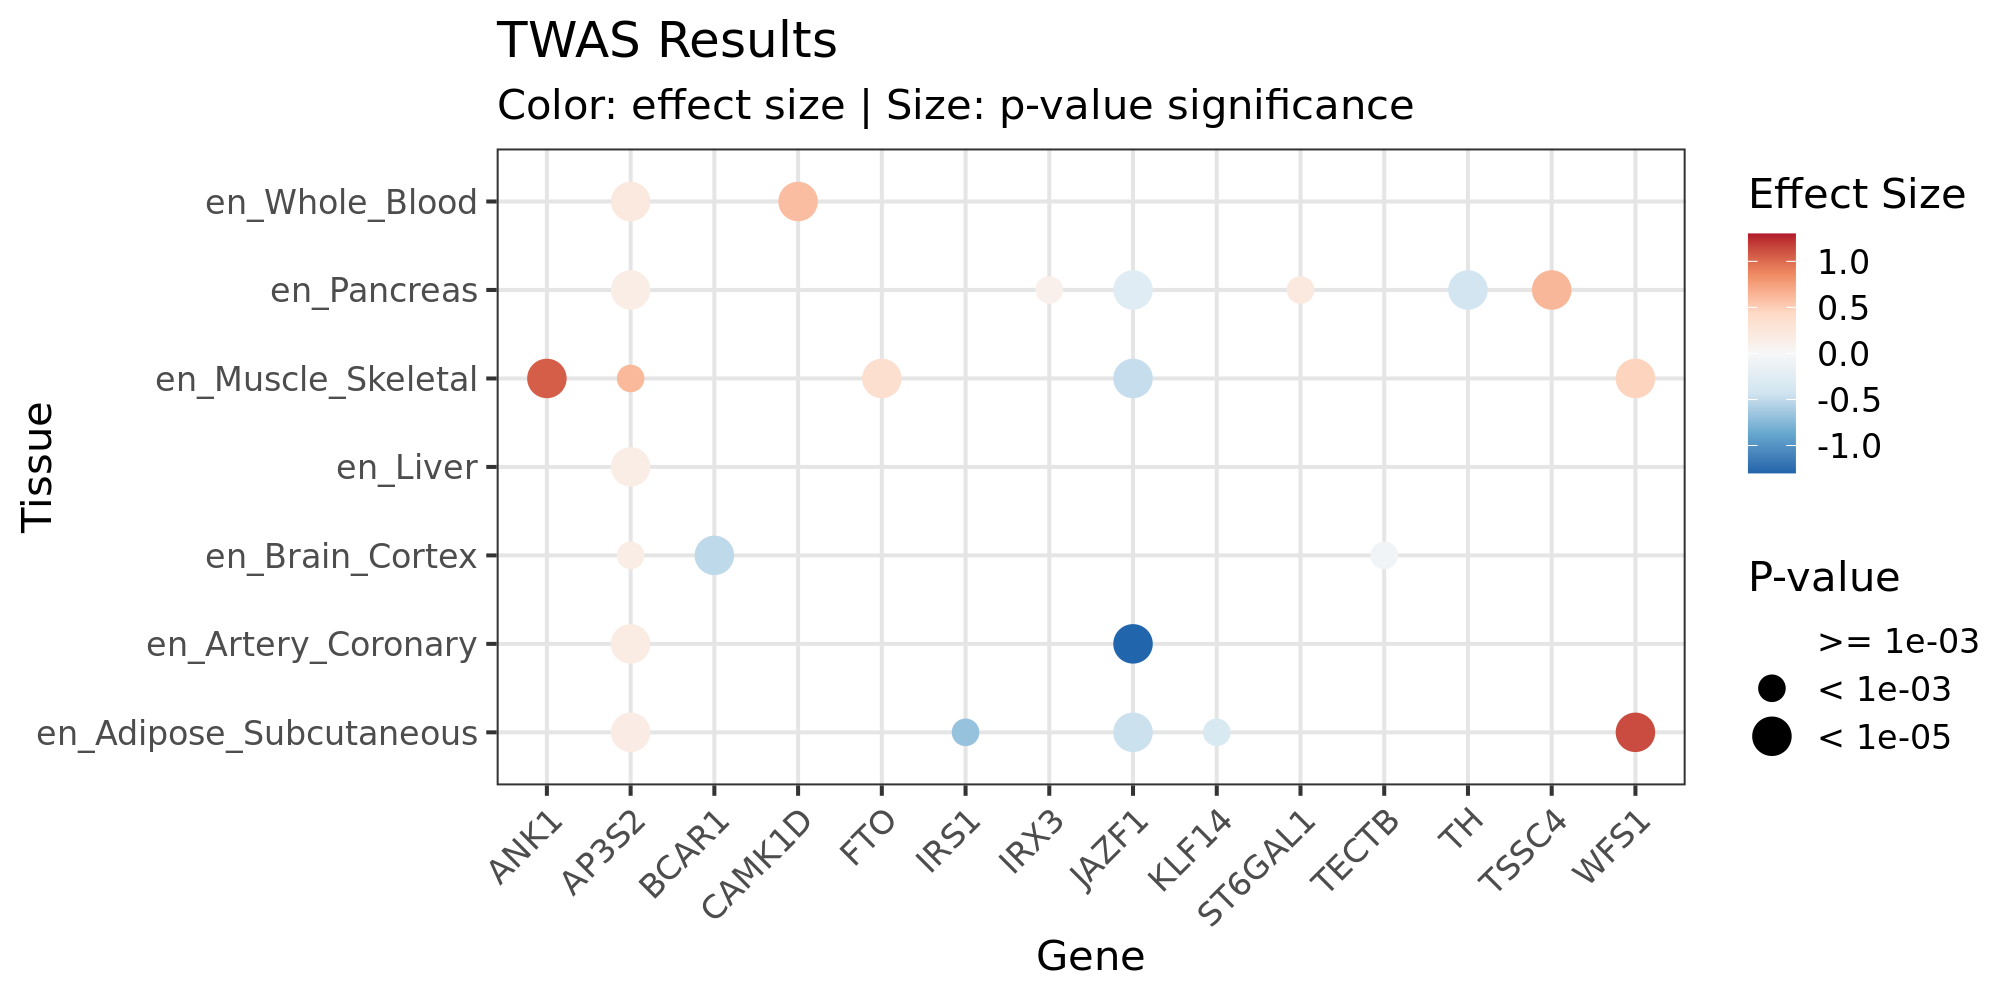

In [5]:
source("/workshop/utilities/gene_tissue_dotplot.R")
options(repr.plot.width = 10, repr.plot.height = 5)
options(repr.plot.res = 200)
plot_gene_tissue_dots_advanced(sig_genes_data)

### Interpréter les patrons d'association : Le graphique en points

La visualisation ci-dessus fournit des informations pour interpréter nos résultats TWAS et leurs implications thérapeutiques potentielles. Chaque point représente une combinaison gène-tissu, avec des caractéristiques clés indiquant :

- **Intensité de couleur :** Niveau de signification (plus foncé = plus significatif)
- **Taille du point :** Significativité de l'association
- **Teinte de couleur :** Direction de l'association (rouge = positive, bleu = négative)

**Interprétation de la direction d'effet :**
- **Association positive (rouge) :** Expression génique génétiquement prédite plus élevée → Risque de DT2 plus élevé
- **Association négative (bleue) :** Expression génique génétiquement prédite plus élevée → Risque de DT2 plus faible

<div class="alert alert-info">
<strong>Évaluation de cibles thérapeutiques :</strong>
<br><br>
Si nous assumons que ces associations reflètent des <strong>relations causales</strong>, quels gènes seraient les cibles thérapeutiques les plus prometteuses pour prévenir le DT2 ? Dans quels tissus les efforts devraient-ils être concentrés ?
<br><br>
<strong>Considération :</strong> Pour le développement de médicaments, nous ciblons typiquement des gènes où :
<ul>
<li>Une expression plus élevée est <em>positivement</em> associée au risque de maladie (candidats au développement d'inhibiteurs)</li>
<li>La livraison thérapeutique dans le tissu d'intérêt sera possible</li>
<li>La taille d'effet est <em>substantielle</em> assez pour fournir un bénéfice thérapeutique significatif</li>
</ul>
<br>
<strong>Exemple :</strong> Basé sur ces critères, des gènes comme <em>WFS1</em> dans le tissu adipeux ou <em>ANK1</em> dans le muscle squelettique peuvent représenter des cibles prometteuses pour l'intervention thérapeutique.
</div>

Ensuite, nous examinons l'architecture génétique sous-jacente à ces associations en investigant comment les signaux TWAS se relient aux variants GWAS sous-jacents.

In [9]:
# Nous définissons la région WFS1 en utilisant les données d'Ensembl.
# Voir : https://useast.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g=ENSG00000109501;r=4:6269849-6303265
# Nous avons ajouté un "padding" de +/- 100kb.
wfs1_region <- list(
    chrom = "chr4",
    start = 6269849 - 100000,
    end = 6303265 + 100000
)

get_predictdb_and_gwas_data <- function(region, gene_name, tissue) {
    # Nous lisons les statistiques sommaires GWAS, mais gardons seulement l'information pour
    # les variants dans la région d'intérêt.
    gwas <- read.csv(
        paste0(
            "/workshop/data/PrediXcan/gwas_harmonized/harmonized_",
            tissue,
            ".tsv.gz"
        ), sep="\t"
    )
    gwas_region <- gwas[
        (gwas$chromosome == region$chrom) &
        (region$start <= gwas$base_pair_location) &
        (gwas$base_pair_location <= region$end),
    ]
    rm(gwas)

    # Nous extrairons le rsid et les poids des variants inclus dans le
    # modèle prédictif d'expression génique.
    db_filename = paste0("/workshop/data/PrediXcan/predictdb/", tissue, ".db")
        
    model <- system(paste0(
        "sqlite3 ",
        db_filename,
        " \"select rsid, weight from weights w, extra e where e.gene=w.gene and e.genename='",
        gene_name, "';\""
    ), intern=T)

    if (length(model) == 0) {
        stop("Ne peut trouver les données PredictDB pour le gène.")
    }

    model <- data.frame(do.call(rbind, strsplit(model, "\\|")))
    colnames(model) <- c("rsid", "weight")
    model$weight <- as.numeric(model$weight)

    # Nous créons des variables indicatrices pour tester si un variant est dans le modèle
    # et nous fixons une valeur par défaut pour les poids à des fins de visualisation.
    gwas_region$in_model <- gwas_region$rsid_x %in% model$rsid

    gwas_region <- merge(gwas_region, model, by.x = "rsid_x", by.y = "rsid", all.x = T)
    min_abs_weight = min(abs(na.omit(gwas_region$weight)))
    gwas_region$weight <- ifelse(
        is.na(gwas_region$weight),
        0.8 * min_abs_weight,
        gwas_region$weight
    )
    
    list(
        model = model,
        gwas_region = gwas_region
    )
}

plot_region <- function(region, gene_name, tissue) {
    data <- get_predictdb_and_gwas_data(region, gene_name, tissue)
    
    options(repr.plot.width = 10, repr.plot.height = 4)
    options(repr.plot.res = 200)
    
    plot <- ggplot(data$gwas_region, aes(x = base_pair_location, y = neg_log_10_p_value,
                      color = in_model, size = abs(weight))) +
        geom_point(alpha = 0.7) +
        scale_color_manual(values = c("FALSE" = "#222222", "TRUE" = "#2E86C1")) +
        labs(x = paste0("Position (", region$chr, " ,GRCh38)"),
             y = "-log10(P)",
             color = paste0("Dans le modèle ", gene_name)) +
        theme_minimal()
    
    plot
}

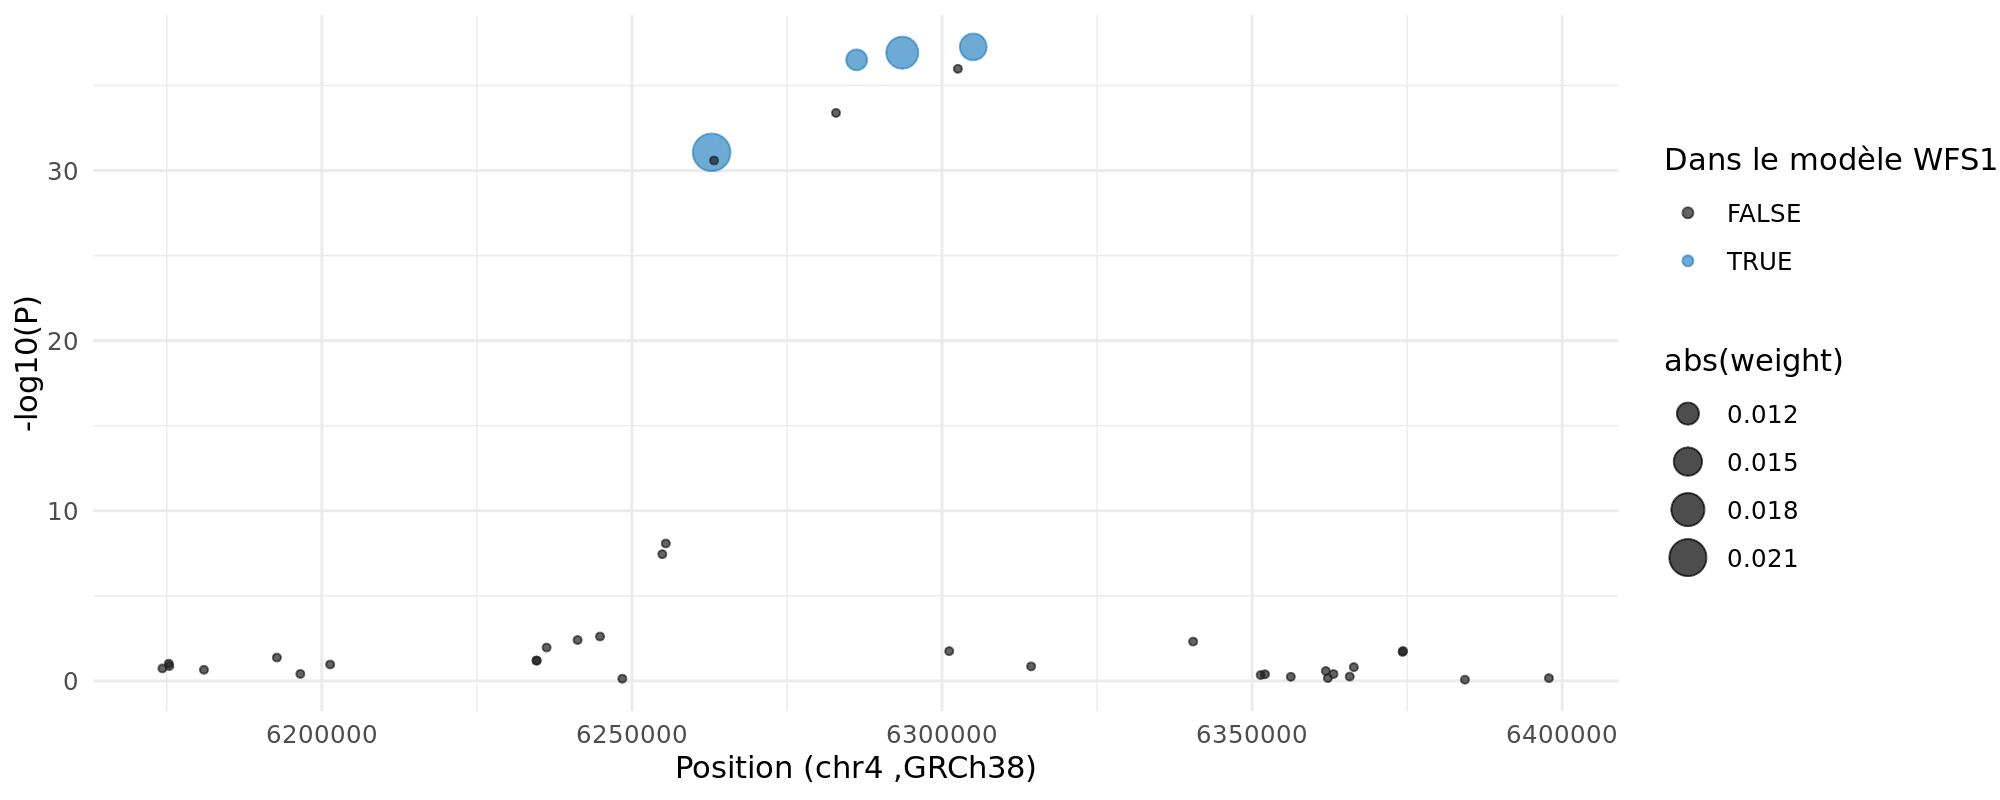

In [10]:
plot_region(wfs1_region, "WFS1", "en_Adipose_Subcutaneous")

### Connecter TWAS à GWAS : Comprendre l'architecture génétique sous-jacente

Le graphique régional ci-dessus est un outil pour valider et interpréter nos découvertes TWAS. Il illustre la relation entre notre association d'expression génique et les variations génétiques sous-jacentes qui sont utilisées pour prédire l'expression du gène.

**Éléments du graphique :**
- **Points gris :** Tous les variants génétiques dans la région *WFS1* testés dans le GWAS DT2
- **Points bleus :** Variants inclus dans le modèle de prédiction d'expression *WFS1* pour le tissu adipeux
- **Taille du point :** Proportionnelle au poids du variant dans le modèle de prédiction
- **Axe Y :** Force d'association avec le DT2 ($-log_{10}(P)$)

<div class="alert alert-info">
<strong>Cadre d'interprétation :</strong>
<br><br>
1. <strong>Validation TWAS :</strong>
   <br><em>Examiner :</em> Les points bleus (variants du modèle) montrent-ils des associations DT2 plus fortes que les variants aléatoires dans la région ?
<br><br>
2. Si le TWAS détectait une association fallacieuse, nous attendrions-nous à ce que les variants du modèle de prédiction soient enrichis pour les signaux d'association DT2 ?
<br><br>
</div>

**Analyse supplémentaire :**
Expérimentez avec le code commenté ci-dessous pour explorer les modèles d'expression *WFS1* dans d'autres tissus, ou essayez de visualiser d'autres gènes significatifs de notre analyse.

**Questions de recherche à explorer :**
- Est-ce que différents tissus utilisent différents ensembles de variants pour prédire l'expression *WFS1* ?
- Les modèles de prédiction spécifiques aux tissus sont-ils supportés par des signaux GWAS spécifiques aux tissus ?
- Comment les gènes avec des associations spécifiques aux tissus (comme *FTO*) se comparent-ils aux gènes avec des associations à travers plusieurs tissus (comme *AP3S2*) ?

In [ ]:
# plot_region(wfs1_region, "WFS1", "en_Whole_Blood")
# plot_region(wfs1_region, "WFS1", "en_Pancreas")
# plot_region(wfs1_region, "WFS1", "en_Muscle_Skeletal")

### Prochaines étapes

Dans le [prochain carnet](./2a-FUSION.ipynb), nous utiliserons TWAS FUSION, un deuxième algorithme TWAS pour voir comment il fonctionne et se compare à S-PrediXcan.